In [3]:
import torch
import torch.nn as nn
from Model import Patchify
import numpy as np
from util import random_indexes, take_indexes
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from einops import repeat, rearrange
from einops.layers.torch import Rearrange
from ai4ha.data.series.MITBIHDataLoader import MITBIHtrain
import matplotlib.pyplot as plt

In [2]:
orig = MITBIHtrain( filename="/home/bejar/ssdstorage/MITBIH/mitbih_test.csv",
                n_samples= 100,
                oneD=True,
                resamp=False,
                fixsize=192)

Class 0 = (18118, 188)
Class 1 = (556, 188)
Class 2 = (1448, 188)
Class 3 = (162, 188)
Class 4 = (1608, 188)
X_train shape is (21892, 1, 192)
y_train shape is (21892,)


In [11]:
data = torch.tensor(orig[0][0]).float().unsqueeze(0)
data.shape

torch.Size([1, 1, 192])

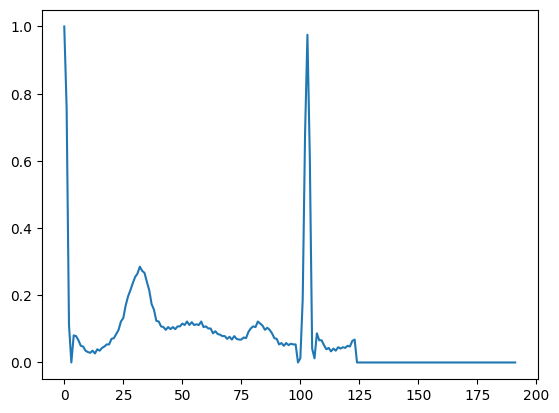

In [12]:
plt.plot(data[0][0].numpy());

In [14]:
emb_dim = 2
input_channels = 1
patch_size = 16
series_length = 192
percent = patch_size//2
batch = 1

In [16]:
patchify = Patchify(input_channels, emb_dim, patch_size=patch_size)
ptc = patchify(data)
ptc.shape

torch.Size([1, 2, 12])

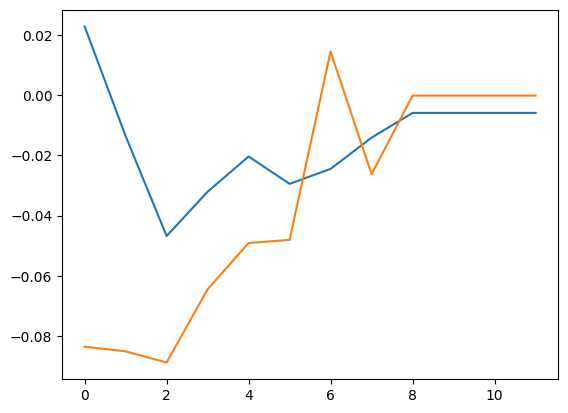

In [21]:
plt.plot(ptc[0][0].detach().numpy())
plt.plot(ptc[0][1].detach().numpy());

In [22]:

ptc = rearrange(ptc, 'b c l -> l b c')
ptc.shape

torch.Size([12, 1, 2])

In [23]:
cls_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
pos_embedding = torch.nn.Parameter(torch.zeros((series_length // patch_size), 1, emb_dim))
ptc = ptc + pos_embedding
indexes = [random_indexes(series_length//patch_size) for _ in range(batch)]
forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long)
backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long)
forward_indexes.shape, backward_indexes.shape, ptc.shape

(torch.Size([12, 1]), torch.Size([12, 1]), torch.Size([12, 1, 2]))

In [39]:
indexes

[(array([ 6,  5,  9, 10,  4,  3,  1,  8,  0, 11,  7,  2]),
  array([ 8,  6, 11,  5,  4,  1,  0, 10,  7,  2,  3,  9]))]

In [32]:
ptc.T[1][0]

tensor([-0.0835, -0.0851, -0.0888, -0.0645, -0.0492, -0.0481,  0.0144, -0.0263,
        -0.0002, -0.0002, -0.0002, -0.0002], grad_fn=<SelectBackward0>)

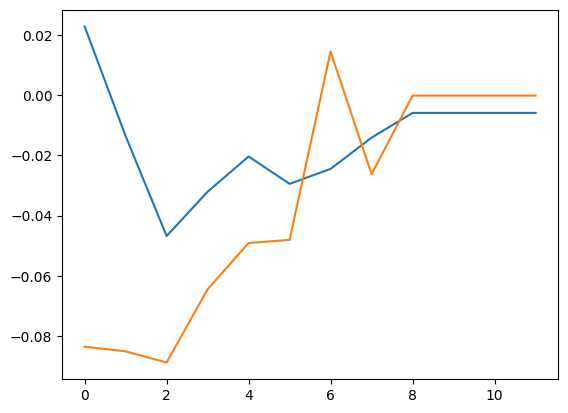

In [33]:
plt.plot(ptc.T[0][0].detach().numpy())
plt.plot(ptc.T[1][0].detach().numpy());

In [34]:
ptc_r =take_indexes(ptc, forward_indexes)
ptc_r = ptc_r[:percent]
ptc_r.shape

torch.Size([8, 1, 2])

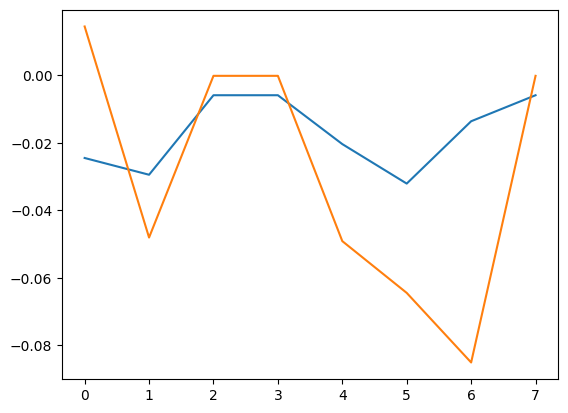

In [36]:
plt.plot(ptc_r.T[0][0].detach().numpy())
plt.plot(ptc_r.T[1][0].detach().numpy());

In [37]:
tre = TransformerEncoderLayer(d_model=emb_dim, nhead=2)
tre_layer = TransformerEncoder(tre, num_layers=3)

features = tre_layer(ptc_r)
T = features.shape[0]
features.shape

torch.Size([8, 1, 2])

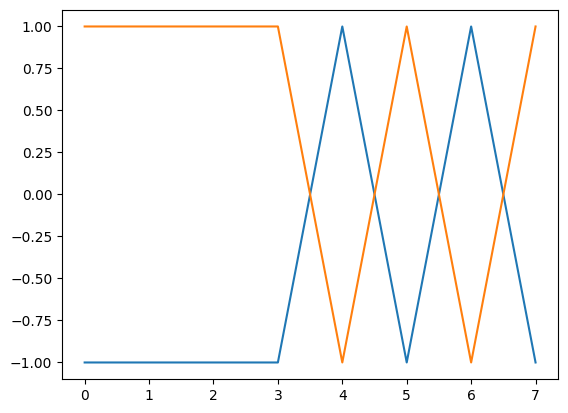

In [38]:
plt.plot(features.T[0][0].detach().numpy())
plt.plot(features.T[1][0].detach().numpy());

### Decoder

In [40]:
mask_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
pos_embedding_d = torch.nn.Parameter(torch.zeros((series_length // patch_size), 1, emb_dim))

In [41]:
trd = TransformerEncoderLayer(d_model=emb_dim, nhead=2)
trd_layer = TransformerEncoder(trd, num_layers=3)
head = torch.nn.Linear(emb_dim, input_channels * patch_size)
patch2img = Rearrange('l b (c p1) -> b c (l p1)', p1=patch_size,  l=series_length//patch_size)

In [211]:
# backward_indexes_d = torch.cat([
#     torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes),
#     backward_indexes
# ],
#                                dim=0)


# backward_indexes_d.shape

In [42]:
backward_indexes.shape[0], features.shape[0], features.shape[1]

(12, 8, 1)

In [43]:

features = torch.cat([features, mask_token.expand(backward_indexes.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
features = take_indexes(features, backward_indexes)
features.shape

torch.Size([12, 1, 2])

In [44]:

features = features + pos_embedding_d

In [45]:
features_d = trd_layer(features)
features_d.shape

torch.Size([12, 1, 2])

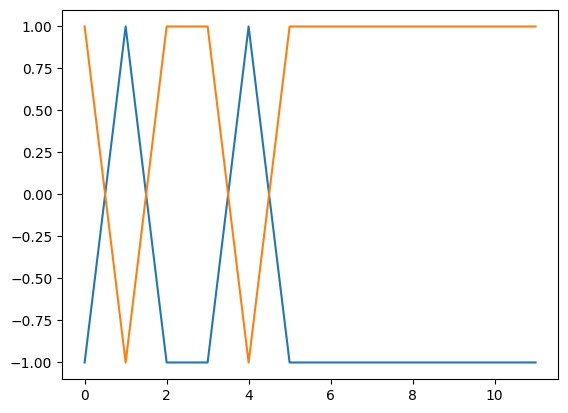

In [46]:
plt.plot(features_d.T[0][0].detach().numpy())
plt.plot(features_d.T[1][0].detach().numpy());

In [47]:
features_d = head(features_d)
features_d.shape

torch.Size([12, 1, 16])

In [48]:
mask = torch.zeros_like(features_d)
mask[T:] = 1
mask = take_indexes(mask, backward_indexes)

In [49]:
features_d = patch2img(features_d)
features_d.shape    

torch.Size([1, 1, 192])

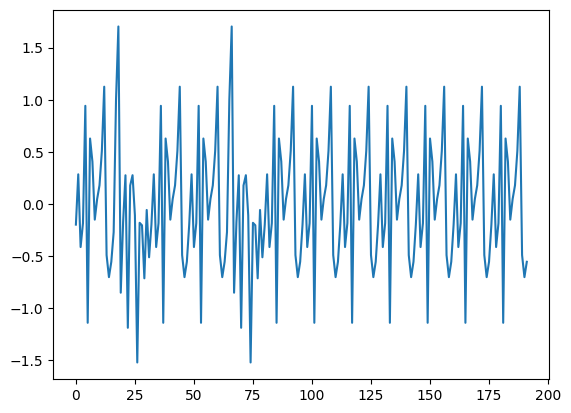

In [51]:
plt.plot(features_d[0][0].detach().numpy());

In [52]:
mask = patch2img(mask)
mask.shape

torch.Size([1, 1, 192])

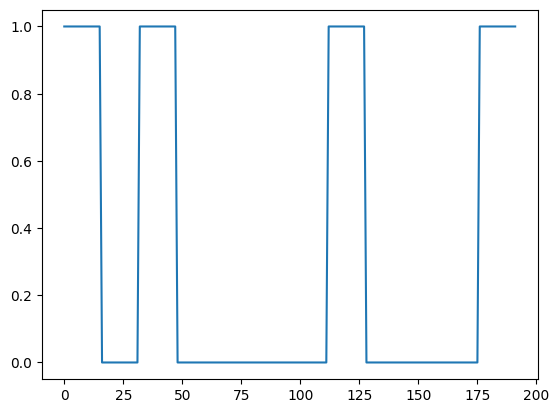

In [53]:
plt.plot(mask[0][0].detach().numpy());

In [54]:
# features_d - a